In [2]:
import re
import math
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import t
import matplotlib.pyplot as plt

In [3]:
n = 30
C = 4

CSV = {
    "Slow": pd.read_csv("Slow_New.csv").fillna(0),
    "Balanced": pd.read_csv("Balanced_New.csv").fillna(0),
    "Fast": pd.read_csv("Fast_New.csv").fillna(0)
}

for key in CSV:
    CSV[key] = CSV[key][CSV[key]["type"] == "vector"]
    CSV[key] = CSV[key][CSV[key]["module"].str.contains("SuperMarket.checkout.queues")]
    CSV[key] = CSV[key][CSV[key]["name"] == "queueingTime:vector"]


Q = []
for i in range(C):
    Q.append(f"Q{i}")

PI = {}
# PI_df: Performance Indexes DataFrame
PI_df = {}

for key in CSV:
    
    # PI: Performance Indexes
    PI[key] = {}

    # Configurations
    config = {}

    for _, row in CSV[key].iterrows():
        # The key of config is the run number and the value is the value of T
        config[row["run"].split("-")[1]] = "BASE"


    pi = "W"
            
    # --- Initialization Phase ---
    # The key of PI is the Performance Index and the value is a dictionary
    PI[key][pi] = {}

    for c in config:
        # config[c] is a value of T
        PI[key][pi][config[c]] = {}

        for cc in config:
            # cc contains the run number
            PI[key][pi][config[c]][cc] = {}
    # --- End of Initialization Phase ---

    for _, row in CSV[key].iterrows():
        # each row of CSV_Dict[key] is a run of the simulation with a specific value of T

        # In row we save the run number
        run = row["run"].split("-")[1]

        # Using a regex we search for all the occurencies of numbers inside row['module']
        q = re.findall(r'\d+', row["module"])

        if q:
            # If a number was found
            # e.g. SuperMarket.checkout.queues[0]
            # We take the first one (and only one)
            q = q[0]

            string = f"Q{q}"
            if pi == "W":
                PI[key][pi][config[run]][run][string] = row["vecvalue"]
                
            else:
                # For the current run we save the PI value of the queue "string" (e.g. Q0)
                PI[key][pi][config[run]][run][string] = float(row["value"]) 

        else:
            # If none number was found
            # e.g. SuperMarket.globalSink

            if pi == "TW":
                PI[key][pi][config[run]][run] = row["vecvalue"]
            else:
                # For the current run we save the PI value of the overall system
                PI[key][pi][config[run]][run] = float(row["value"])


    
    PI_df[key] = {}

    # --- Initialization Phase ---

    for pi in PI[key]:

        # The key of PI_df is the Performance Index and the value is a dictionary
        PI_df[key][pi] = {}

        for config in PI[key][pi]:

            if pi != "TW":
                # If pi is not TW we create a DataFrame with the columns Q (one column for each queue)
                PI_df[key][pi][config] = pd.DataFrame(columns=Q)

            else:
                # If pi is TW we create a DataFrame with just one column GS (Global Sink)
                PI_df[key][pi][config] = pd.DataFrame(columns=["GS"])

    # --- End of Initialization Phase ---


    for pi in PI[key]:

        for config in PI[key][pi]:
        
            for run in PI[key][pi][config]:
                
                # Here we need to check if PI[key][pi][config][run] is different from {}
                # because if it is {} it means that the run was not related to 
                # that specific value of T
                if PI[key][pi][config][run]:

                    # Check if PI[key][pi][config][run] is a dictionary
                    if isinstance(PI[key][pi][config][run], dict):
                        # If it is a dictionary it means that
                        # it contains the PI values for each queue
                        for q in PI[key][pi][config][run]:
                            # We add the PI value of the queue q to the DataFrame
                            # at the row 'run' and at the column 'q'
                            PI_df[key][pi][config].loc[int(run), q] = PI[key][pi][config][run][q]
                    else:
                        # If it is not a dictionary it means that
                        # it contains the PI value for the overall system

                        # We add the PI value of the overall system to the DataFrame
                        # at the row 'run'
                        PI_df[key][pi][config].loc[int(run)] = PI[key][pi][config][run]

            # We sort the DataFrame by the index (run number)
            PI_df[key][pi][config] = PI_df[key][pi][config].sort_index()
            # We reset the index of the DataFrame to start from 0
            PI_df[key][pi][config] = PI_df[key][pi][config].reset_index(drop=True)




In [4]:
CSV["Slow"]

,run,type,module,name,attrname,attrvalue,value,vectime,vecvalue
15166,Slow-0-20240125-18:00:15-7888,vector,SuperMarket.checkout.queues[2],queueingTime:vector,0,0,0,47.752470273947 113.752470273947 803.752470273...,0 12.086376690964 626.73053120812 152.61771614...
15181,Slow-0-20240125-18:00:15-7888,vector,SuperMarket.checkout.queues[3],queueingTime:vector,0,0,0,288.598191790306 621.054211482701 1437.0542114...,0 0 577.19875719182 120.17143222851 40.6783134...
15186,Slow-0-20240125-18:00:15-7888,vector,SuperMarket.checkout.queues[0],queueingTime:vector,0,0,0,343.991579678554 461.084299831622 508.31636823...,0 0 0 0 0 0 0 0 0 0 28.578878672095 0 0 0 3.90...
15201,Slow-0-20240125-18:00:15-7888,vector,SuperMarket.checkout.queues[1],queueingTime:vector,0,0,0,18925.223064489767 23578.832601000215 26324.50...,0 0 0 0 0 0 0
15227,Slow-1-20240125-18:00:15-10132,vector,SuperMarket.checkout.queues[2],queueingTime:vector,0,0,0,48.016943453557 450.016943453557 723.016943453...,0 397.59897372214 415.48372324786 380.87568547...
...,...,...,...,...,...,...,...,...,...
16909,Slow-28-20240125-18:00:43-11096,vector,SuperMarket.checkout.queues[1],queueingTime:vector,0,0,0,5433.331487504679 19757.616096868805 57139.758...,0 0 0 0
16935,Slow-29-20240125-18:00:43-19148,vector,SuperMarket.checkout.queues[2],queueingTime:vector,0,0,0,64.072912879819 208.375647403472 394.309866847...,0 0 0 67.840136089332 137.66849790122 118.6181...
16950,Slow-29-20240125-18:00:43-19148,vector,SuperMarket.checkout.queues[3],queueingTime:vector,0,0,0,678.629923265479 804.629923265479 1071.6299232...,0 119.82271698477 320.41316386864 74.702255623...
16960,Slow-29-20240125-18:00:43-19148,vector,SuperMarket.checkout.queues[0],queueingTime:vector,0,0,0,809.859106324535 1090.331962944023 1217.124445...,0 0 0 0 0 0 2.620905872747 0 32.879564654457 0...


In [5]:
PI_df["Balanced"]["W"]["BASE"]

,Q0,Q1,Q2,Q3
0,0 0 0 0 0 0 0 0 0 0 15.789439336048 0 0 0 1.95...,0 0 0 0 0 0 0 0 0 0 0 0 0,0 6.043188345482 307.36526560406 68.8088580721...,0 0 279.59937859591 51.085716114257 11.3391567...
1,0 0 17.432220535702 7.063395264964 0 0 0 0 0 1...,0 11.032848525935 0 0 5.05747196931 0 0 0 0 0,0 195.79948686107 203.24186162393 185.93784273...,0 0 203.11967215528 270.39736973763 170.547481...
2,0 0 0 0 0 0 0 0 1.218333779243 0 0 0 0 0 0 0 4...,0 0 0 0 0 0 0 0 0 0 0 0 0,0 31.301354990957 50.16499904287 0 22.21776781...,0 220.72227368098 278.43886987459 41.377005098...
3,0 3.092897483344 0 0 0 0 18.365878779944 5.529...,0 0 0 0 0 0 0 0 0 15.078704677129 0 0 0 0 0,0 31.752158931323 48.672922565181 118.26916186...,0 59.772849206974 75.460462167173 26.035241503...
4,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3.094305748228...,0 0 0 0 0 0 0 0 0,0 72.270271958758 26.853688428742 106.08352586...,0 99.288001271521 153.43426701666 161.09200558...
5,0 0 0.793818184195 11.33300361066 0 0 17.24191...,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0,0 21.086837719032 37.562681737138 7.6950141691...,0 97.666950168206 125.99839620856 0 28.5650299...
6,0 0 3.565869045503 0 0 8.652796680737 0 0 0 0 ...,0 0 0 0 0 0 0 0 0 0 0 0 0,0 14.876584577143 81.874514195623 0 20.1563573...,0 0 227.13857229341 72.830179466003 56.5852174...
7,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,0 0 0 0 0 0 0 0,0 61.762887150368 28.301964218065 59.541849423...,0 38.602797377692 0 109.43677240148 0 12.71735...
8,0 9.540734920378 0 0 0 0 0 0.963484831843 0 0 ...,0 0 0 0 20.513629496078 0 0 0 0,0 109.53735953175 0 0 49.723457912735 37.81673...,0 52.370919632568 0 2.66881985254 1.8754084476...
9,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,0 0 0 0 0 0 0 0 0 0 8.128153042061,0 7.781372474085 0 18.436100070473 0 0 34.9391...,0 0 102.88477559706 64.039917267415 134.479384...


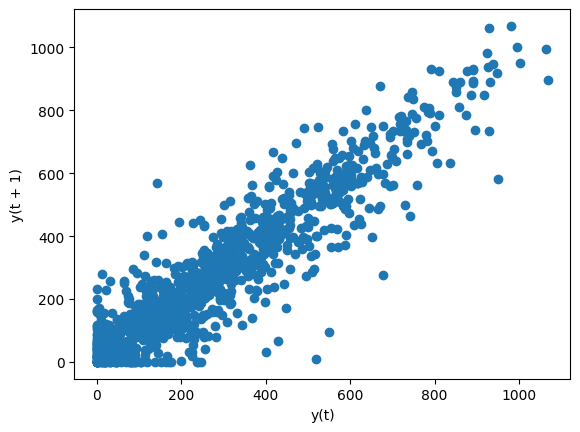

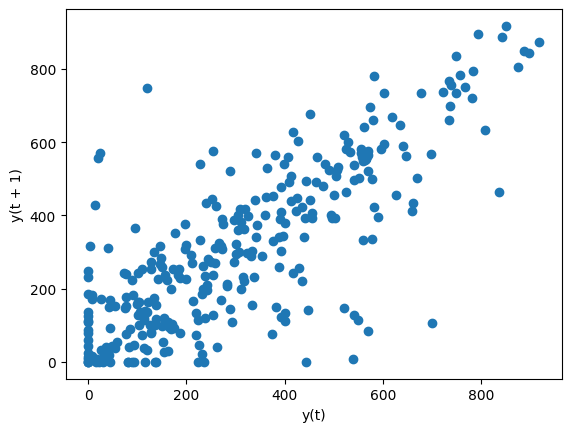

C:\Users\giova\AppData\Local\Temp\ipykernel_14096\628951461.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(values, hist=False, fit=stats.lognorm,
C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_continuous_distns.py:6120: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
C:\Users\giova\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in

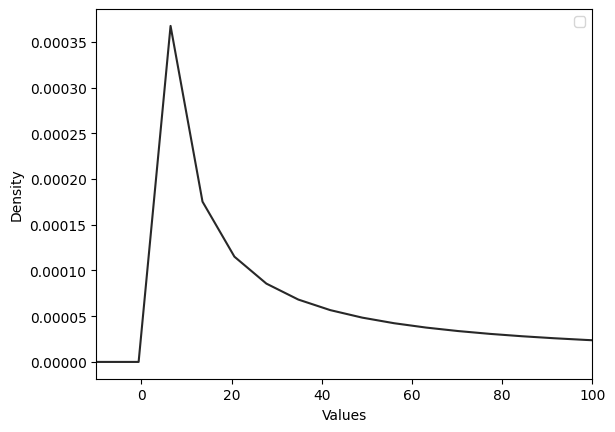

In [6]:
from statsmodels.graphics.gofplots import qqplot
from pandas.plotting import lag_plot
import scipy.stats as stats

values = PI_df["Balanced"]["W"]["BASE"]["Q2"].iloc[6]
values = values.split(" ")
values = [float(i) for i in values]
values = pd.DataFrame(values)
lag_plot(values)
plt.show()
subsample = values.sample(frac=0.3)
subsample.sort_index(inplace=True)
lag_plot(subsample)
plt.show()
sns.distplot(values, hist=False, fit=stats.lognorm, 
             kde=False,  # Disabilita il KDE
            )

#Aggiungi le etichette e la legenda
plt.xlim(-10,100)
plt.xlabel("Values")
plt.ylabel("Density")
plt.legend()

#Mostra il grafico
plt.show()
#Imposta il contesto di Seaborn (opzionale)
sns.set()


In [7]:
# Subsampling and Mean Computation
for key in PI_df:
    for pi in PI_df[key]:
        for config in PI_df[key][pi]:
            for index, row in PI_df[key][pi][config].iterrows():
                if pi != "TW":
                    for q in Q:
                        values = row[q].split(" ")
                        values = [float(v) for v in values]
                        values = pd.DataFrame(values)
                        subsample = values.sample(frac=0.5)
                        PI_df[key][pi][config].loc[index, q] = subsample.mean()[0]
                else:
                    values = row["GS"].split(" ")
                    values = [float(v) for v in values]
                    values = pd.DataFrame(values)
                    subsample = values.sample(frac=0.3)
                    PI_df[key][pi][config].loc[index, "GS"] = subsample.mean()[0]

In [8]:
PI_df["Slow"]["W"]["BASE"]

,Q0,Q1,Q2,Q3
0,2.615262,0.0,405.65536,380.573315
1,1.678585,4.766424,646.909135,656.761259
2,2.926814,0.0,592.489142,605.583746
3,2.326284,0.0,314.62226,304.178525
4,2.124456,0.0,665.429838,632.993942
5,2.515908,0.0,796.45843,928.440419
6,2.003565,0.0,638.232911,623.555323
7,1.949653,0.0,453.608361,401.991835
8,1.937349,0.0,372.268424,328.36407
9,1.260195,0.0,472.408219,467.114475


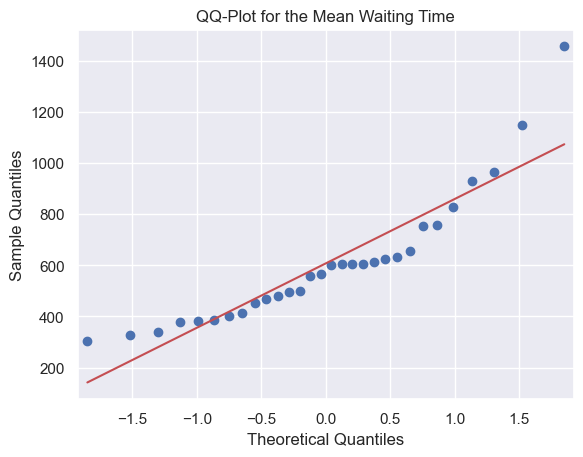

In [17]:
from statsmodels.graphics.gofplots import qqplot

qqplot(PI_df["Slow"]["W"]["BASE"]["Q3"], line='s')
plt.title('QQ-Plot for the Mean Waiting Time')
plt.show()

In [10]:
# Quick Tills
QT = ["Q2", "Q3"]

pi = "W"
P_LOG = {}
for key in PI_df:
    P_LOG[key] = {}
    for pi in PI_df[key]:
        P_LOG[key][pi] = {}
        for config in PI_df[key][pi]:
            P_LOG[key][pi][config] = pd.DataFrame(columns=QT)
            for q in QT:
                P_LOG[key][pi][config][q] = np.log(PI_df[key][pi][config][q].values.astype(np.float64).tolist())

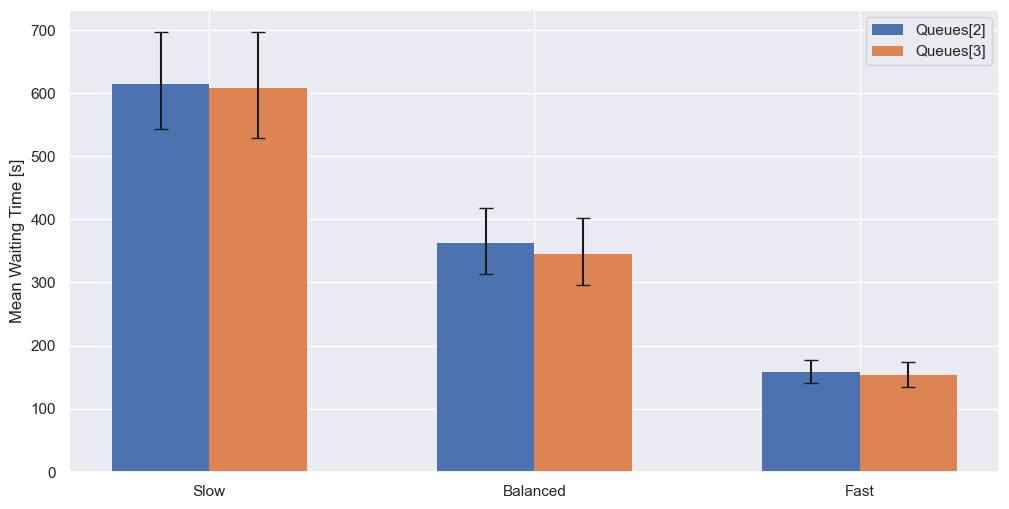

In [11]:
# width of the bars
barWidth = 0.3

sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))

# Choose the height of the bars
Q1_bars = []
Q3_bars = []
for key in PI_df:
    Q1_bars.append(PI_df[key]["W"]["BASE"]["Q2"].mean())
    Q3_bars.append(PI_df[key]["W"]["BASE"]["Q3"].mean())


# Choose the height of the error bars 
yerr_Q2_LB = []
yerr_Q2_UB = []
yerr_Q3_LB = []
yerr_Q3_UB = []
for key in PI_df:
    yerr_Q2_LB.append(PI_df[key]["W"]["BASE"]["Q2"].mean() - np.exp(P_LOG[key]["W"]["BASE"]["Q2"].mean() + (P_LOG[key]["W"]["BASE"]["Q2"].std()**2 / 2) - (1.96 * np.sqrt((P_LOG[key]["W"]["BASE"]["Q2"].std()**2 / n) + (P_LOG[key]["W"]["BASE"]["Q2"].std()**4 / (2 * (n-1)))))))
    yerr_Q2_UB.append(np.exp(P_LOG[key]["W"]["BASE"]["Q2"].mean() + (P_LOG[key]["W"]["BASE"]["Q2"].std()**2 / 2) + (1.96 * np.sqrt((P_LOG[key]["W"]["BASE"]["Q2"].std()**2 / n) + (P_LOG[key]["W"]["BASE"]["Q2"].std()**4 / (2 * (n-1)))))) - PI_df[key]["W"]["BASE"]["Q2"].mean())

    yerr_Q3_LB.append(PI_df[key]["W"]["BASE"]["Q3"].mean() - np.exp(P_LOG[key]["W"]["BASE"]["Q3"].mean() + (P_LOG[key]["W"]["BASE"]["Q3"].std()**2 / 2) - (1.96 * np.sqrt((P_LOG[key]["W"]["BASE"]["Q3"].std()**2 / n) + (P_LOG[key]["W"]["BASE"]["Q3"].std()**4 / (2 * (n-1)))))))
    yerr_Q3_UB.append(np.exp(P_LOG[key]["W"]["BASE"]["Q3"].mean() + (P_LOG[key]["W"]["BASE"]["Q3"].std()**2 / 2) + (1.96 * np.sqrt((P_LOG[key]["W"]["BASE"]["Q3"].std()**2 / n) + (P_LOG[key]["W"]["BASE"]["Q3"].std()**4 / (2 * (n-1)))))) - PI_df[key]["W"]["BASE"]["Q3"].mean())


# The x position of bars
r1 = np.arange(len(Q1_bars))
r2 = [x + barWidth for x in r1]
 
# Create Q0 bars
plt.bar(r1, Q1_bars, width = barWidth, edgecolor = 'black', yerr=[yerr_Q2_LB, yerr_Q2_UB], capsize=5, label='Queues[2]', lw=0)
 
# Create Q1 bars
plt.bar(r2, Q3_bars, width = barWidth, edgecolor = 'black', yerr=[yerr_Q3_LB, yerr_Q3_UB], capsize=5, label='Queues[3]', lw=0)

# General layout
plt.xticks([r + barWidth/2 for r in range(len(Q1_bars))], PI_df.keys()) 

# Show graphic
# plt.title('Consistency Test: Bar Plot with CIs for the Waiting Time of Queues[2] and Queues[3] for the three different configurations')
plt.ylabel('Mean Waiting Time [s]')

plt.legend()
plt.show()
